In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from mlens.visualization import corrmat


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

[MLENS] backend: threading


In [2]:
df = pd.read_pickle("outputs/df_cleaned.pickle")
SEED = 42
features = df.iloc[:, :-1]
response = df.iloc[:, -1]
le = LabelEncoder().fit(response)
features_scaled = StandardScaler().fit_transform(features)
response_tf = le.transform(response)
X_train, x_test, y_train, y_test = train_test_split(
    features_scaled,
    response_tf,
    test_size=0.2,
    random_state=42
)

In [3]:
def get_models():
    lr = LogisticRegression(C=1000.0, penalty="l1")
    gb = GradientBoostingClassifier(
        learning_rate=.05,
         max_depth=5,
         min_samples_leaf=0.1,
         min_samples_split=0.1,
         n_estimators=100
    )
    rf = RandomForestClassifier(
        criterion='gini',
        max_depth=8,
         max_features='auto',
         n_estimators=200
    )
    models = {
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }
    return models

In [4]:
def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(X_train, y_train)
        P.iloc[:, i] = m.predict_proba(x_test)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [5]:
models = get_models()
P = train_predict(models)
score_models(P, y_test)

Fitting models.
random forest... done
gbm... done
logistic... 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


done
Done.

Scoring models.
random forest             : 0.725
gbm                       : 0.720
logistic                  : 0.692
Done.



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


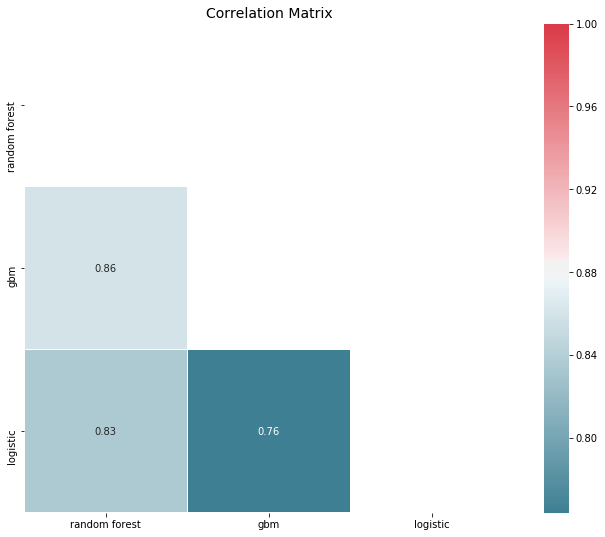

In [6]:
corrmat(P.corr(), inflate=False)
plt.show()

In [7]:
corrmat(P.apply(lambda pred: 1*(pred >= 0.5) - y_test.values).corr(), inflate=False)
plt.show()

AttributeError: ("'numpy.ndarray' object has no attribute 'values'", 'occurred at index random forest')

In [8]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(y_test, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.724
